In [74]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import NeuralABC_tools as nabc
from nilearn import masking, plotting
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from statsmodels.formula.api import ols
import statsmodels as sm
from sklearn.linear_model import LinearRegression

In [75]:
'''
Retrieve the trait data containing physical and mental attributes.
'''

#df2 contains brain volume data
df2 = pd.read_csv('unrestricted_hcp_freesurfer.csv')

beh_all_res = pd.read_csv("/data/neuralabc/alazak/hcp_csv/unrestricted_alasmarz_5_3_2020_16_16_47.csv")
restricted_data = pd.read_csv("/data/neuralabc/alazak/hcp_csv/RESTRICTED_alasmarz_6_1_2020_10_17_41.csv")

In [76]:
'''
pers will be the DataFrame which we conduct regression on.
Excluding'Subject', the following columns contain variables relevant for our regression.
'''

pers = beh_all_res[['Subject','Age', 'Gender', 'NEOFAC_N', 'NEOFAC_A' ,'Strength_AgeAdj','Flanker_AgeAdj', 'ReadEng_Unadj',
 'ReadEng_AgeAdj',
 'PicVocab_AgeAdj',
 'ProcSpeed_AgeAdj',
 'Dexterity_AgeAdj']]

In [77]:
#Retrieve the total brain volume of each subject
total_brain_volumes = df2[['Subject','FS_BrainSeg_Vol']]

In [78]:
'''
We copy the BMI and age data from the restricted dataset to pers. BMI and age are personally identifiable 
information, leading them to be stored in a separate restricted dataset
'''

pers['BMI'] = restricted_data['BMI']
pers['Age'] = restricted_data['Age_in_Yrs']


<ipython-input-78-b68a97fb3321>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pers['BMI'] = restricted_data['BMI']
<ipython-input-78-b68a97fb3321>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pers['Age'] = restricted_data['Age_in_Yrs']


In [79]:
pers

,Subject,Age,Gender,NEOFAC_N,NEOFAC_A,Strength_AgeAdj,Flanker_AgeAdj,ReadEng_Unadj,ReadEng_AgeAdj,PicVocab_AgeAdj,ProcSpeed_AgeAdj,Dexterity_AgeAdj,BMI
0,100004,24,M,24.0,27.0,119.30,111.01,109.9589,96.91405,104.93750,69.88,83.77,25.49
1,100206,27,M,21.0,29.0,129.43,116.55,113.5460,103.44410,117.03610,131.89,94.23,26.64
2,100307,27,F,15.0,37.0,84.59,101.90,111.0700,98.73000,96.81000,112.36,105.21,22.96
3,100408,33,M,15.0,33.0,124.24,113.51,131.8100,125.64000,132.63000,96.00,106.24,27.75
4,100610,27,M,7.0,31.0,118.90,114.18,141.3166,132.41240,146.59710,96.12,107.85,36.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,992774,35,M,16.0,36.0,126.54,115.80,108.6900,93.39000,87.94000,107.51,97.90,21.61
1202,993675,29,F,10.0,42.0,74.13,106.46,129.4080,125.04520,140.09330,99.57,107.64,27.28
1203,994273,30,M,22.0,28.0,119.20,115.11,141.3166,130.86070,113.93770,63.93,83.36,25.87
1204,995174,25,M,18.0,27.0,96.32,87.88,117.1575,109.76300,90.95569,99.57,94.93,23.72


In [80]:
'''
Not all of the 1206 sujects have brain scans that we could use for regression. 
We will whittle down pers into a new DataFrame, merged, which contains only those that do have one.
'''

#subID contains the IDs of the 1001 subjects that do have brain scans
subID = pd.DataFrame(pd.read_csv("/data/neuralabc/pirami/preprocess/list_1001_participants.txt", delimiter=' ').columns)
subID = subID.rename(columns={0:'Subject'})
subjects = list(subID)

merged = pd.merge(pers, subID.astype('float32'), on='Subject')

In [81]:
'''
Next, we need to replace the gender values of 'M' and 'F' with numerical values so that our regression
could handle them:
'''

merged['Gender'] = merged['Gender'].replace({'F':1, 'M':0})
merged

,Subject,Age,Gender,NEOFAC_N,NEOFAC_A,Strength_AgeAdj,Flanker_AgeAdj,ReadEng_Unadj,ReadEng_AgeAdj,PicVocab_AgeAdj,ProcSpeed_AgeAdj,Dexterity_AgeAdj,BMI
0,100206,27,0,21.0,29.0,129.43,116.55,113.5460,103.4441,117.03610,131.89,94.23,26.64
1,100307,27,1,15.0,37.0,84.59,101.90,111.0700,98.7300,96.81000,112.36,105.21,22.96
2,100408,33,0,15.0,33.0,124.24,113.51,131.8100,125.6400,132.63000,96.00,106.24,27.75
3,100610,27,0,7.0,31.0,118.90,114.18,141.3166,132.4124,146.59710,96.12,107.85,36.91
4,101006,35,1,13.0,30.0,106.93,92.33,113.5374,101.1697,69.45302,71.99,96.00,30.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,992774,35,0,16.0,36.0,126.54,115.80,108.6900,93.3900,87.94000,107.51,97.90,21.61
997,993675,29,1,10.0,42.0,74.13,106.46,129.4080,125.0452,140.09330,99.57,107.64,27.28
998,994273,30,0,22.0,28.0,119.20,115.11,141.3166,130.8607,113.93770,63.93,83.36,25.87
999,995174,25,0,18.0,27.0,96.32,87.88,117.1575,109.7630,90.95569,99.57,94.93,23.72


In [82]:
'''
Now, we load the processed brain data. The following file contains the principal component data
for the 1001 subjects above.
'''

PC = np.load("ScaledReshaped1001PC1.npy")
print(PC.shape)

(1001, 119387)


In [85]:
'''
We copy the PC data into our DataFrame. We did this because our regression library
works best when regressing on the columns of a DataFrame.
'''

#tqdm adds some progress-bar entertainment to the bore of waiting for for-loops to finish
from tqdm import tqdm

for _i in tqdm(range(len(PC[0]))):
    merged['PC1_vox' + str(_i)] = pc_1[:,_i]

100%|██████████| 119387/119387 [13:29<00:00, 147.57it/s]


In [86]:
#Notice that we now have more than a hundred thousand columns!
merged

,Subject,Age,Gender,NEOFAC_N,NEOFAC_A,Strength_AgeAdj,Flanker_AgeAdj,ReadEng_Unadj,ReadEng_AgeAdj,PicVocab_AgeAdj,...,PC1_vox119377,PC1_vox119378,PC1_vox119379,PC1_vox119380,PC1_vox119381,PC1_vox119382,PC1_vox119383,PC1_vox119384,PC1_vox119385,PC1_vox119386
0,100206,27,0,21.0,29.0,129.43,116.55,113.5460,103.4441,117.03610,...,-0.149095,0.368346,0.391484,0.540853,0.675777,-0.431629,-0.727993,-2.311761,-0.773290,0.503718
1,100307,27,1,15.0,37.0,84.59,101.90,111.0700,98.7300,96.81000,...,-0.000182,0.263075,0.104168,-0.023164,-1.282692,-1.806334,-2.226357,-2.540319,-2.975938,0.459809
2,100408,33,0,15.0,33.0,124.24,113.51,131.8100,125.6400,132.63000,...,0.374967,0.428063,0.449895,0.596211,-2.005765,-0.608663,-1.245070,-0.194806,0.699492,0.456125
3,100610,27,0,7.0,31.0,118.90,114.18,141.3166,132.4124,146.59710,...,0.401685,0.342907,0.367430,0.372616,0.446808,-1.162351,0.283161,-1.802440,-1.069602,0.484691
4,101006,35,1,13.0,30.0,106.93,92.33,113.5374,101.1697,69.45302,...,0.126265,0.454582,0.304750,0.199454,0.788345,0.830802,0.316103,0.016129,0.490595,0.107363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,992774,35,0,16.0,36.0,126.54,115.80,108.6900,93.3900,87.94000,...,0.433691,0.402215,0.500047,0.459976,1.016850,0.922685,1.014914,0.777811,0.888462,0.534764
997,993675,29,1,10.0,42.0,74.13,106.46,129.4080,125.0452,140.09330,...,0.358150,0.214564,0.494638,0.524218,-3.153817,-0.823532,-0.060741,0.914162,0.358850,0.465616
998,994273,30,0,22.0,28.0,119.20,115.11,141.3166,130.8607,113.93770,...,-0.031827,-0.458453,-0.582063,-0.769742,-0.686438,-0.579669,-0.744537,-0.404731,-0.462447,0.322451
999,995174,25,0,18.0,27.0,96.32,87.88,117.1575,109.7630,90.95569,...,-1.117623,0.104713,0.066819,0.050992,0.699216,0.790251,0.349094,0.877371,0.848163,-0.292139


In [87]:
scaler = StandardScaler()

In [88]:
'''
Add the brain volume data to merged then standardize the entire dataset.
'''

merged = pd.merge( tbv, merged, on='Subject')
merged_std = pd.DataFrame(scaler.fit_transform(merged), columns=merged.columns)

In [89]:
merged_std

,Subject,FS_BrainSeg_Vol,Age,Gender,NEOFAC_N,NEOFAC_A,Strength_AgeAdj,Flanker_AgeAdj,ReadEng_Unadj,ReadEng_AgeAdj,...,PC1_vox119377,PC1_vox119378,PC1_vox119379,PC1_vox119380,PC1_vox119381,PC1_vox119382,PC1_vox119383,PC1_vox119384,PC1_vox119385,PC1_vox119386
0,-1.016834,1.951582,-0.478283,-1.117783,0.599497,-0.816107,1.319087,1.483323,-0.316836,-0.237668,...,-0.149095,0.368346,0.391484,0.540853,0.675777,-0.431629,-0.727993,-2.311761,-0.773290,0.503718
1,-1.016465,-0.533922,-0.478283,0.894628,-0.216810,0.576363,-0.915761,0.017263,-0.552594,-0.557385,...,-0.000182,0.263075,0.104168,-0.023164,-1.282692,-1.806334,-2.226357,-2.540319,-2.975938,0.459809
2,-1.016097,0.891588,1.152932,-1.117783,-0.216810,-0.119872,1.060415,1.179103,1.422217,1.267688,...,0.374967,0.428063,0.449895,0.596211,-2.005765,-0.608663,-1.245070,-0.194806,0.699492,0.456125
3,-1.015359,1.236055,-0.478283,-1.117783,-1.305220,-0.467990,0.794266,1.246152,2.327413,1.727001,...,0.401685,0.342907,0.367430,0.372616,0.446808,-1.162351,0.283161,-1.802440,-1.069602,0.484691
4,-1.013913,-1.001764,1.696670,0.894628,-0.488913,-0.642048,0.197676,-0.940429,-0.317655,-0.391921,...,0.126265,0.454582,0.304750,0.199454,0.788345,0.830802,0.316103,0.016129,0.490595,0.107363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2.242097,-0.312453,1.696670,-1.117783,-0.080759,0.402304,1.175048,1.408269,-0.779212,-0.919551,...,0.433691,0.402215,0.500047,0.459976,1.016850,0.922685,1.014914,0.777811,0.888462,0.534764
997,2.245387,-1.138619,0.065455,0.894628,-0.897067,1.446656,-1.437093,0.473593,1.193505,1.227348,...,0.358150,0.214564,0.494638,0.524218,-3.153817,-0.823532,-0.060741,0.914162,0.358850,0.465616
998,2.247570,0.506110,0.337324,-1.117783,0.735548,-0.990166,0.809218,1.339219,2.327413,1.621763,...,-0.031827,-0.458453,-0.582063,-0.769742,-0.686438,-0.579669,-0.744537,-0.404731,-0.462447,0.322451
999,2.250860,0.669141,-1.022022,-1.117783,0.191343,-1.164224,-0.331132,-1.385751,0.027042,0.190888,...,-1.117623,0.104713,0.066819,0.050992,0.699216,0.790251,0.349094,0.877371,0.848163,-0.292139


In [ ]:
'''
We define a set of independent variables which we want to regress with the voxel PC values.
The following regression code will take more than an hour to run. 
'''

dependent_variables = ['NEOFAC_N', 'NEOFAC_A', 'Strength_AgeAdj', 'Flanker_AgeAdj', 'ReadEng_AgeAdj', 'PicVocab_AgeAdj', 'ProcSpeed_AgeAdj', 'BMI', 'Dexterity_AgeAdj']

r2_all = {}
beta_all = {}

for var in dependent_variables:

    r2_dict = {}
    beta_dict = {}

    for voxelInd in tqdm(range(len(PC[0]))):
        
        
        '''
        This is an R-string. We are adding age, gender, and brain volume as covariates
        In an R-String, the variables on the left of the tilde ('~') are the dependent variables, 
        and the items on the right are the independent variables.
        
        In this case, we will determine if a relationship exists between the dependent variable (e.g. Neuroticism), 
        the PC1 value in the voxel, and the covariates.
        '''
        model = ols(f'{var} ~ PC1_vox{voxelInd} + Age + Gender + FS_BrainSeg_Vol', data=merged_std)
        fitted = model.fit()
        r2_dict[voxelInd] = fitted.rsquared
        beta_dict[voxelInd] = fitted.params[f'PC1_vox{voxelInd}']
    
    r2_all[var] = r2_dict
    beta_all[var] = beta_dict
    
'''
The outputs of the regressions are stored in two dictionaries: r2_all for the r^2 values, and beta_all for the slope values
of the best fit lines.
'''

 88%|████████▊ | 104729/119387 [11:00<01:48, 135.11it/s]

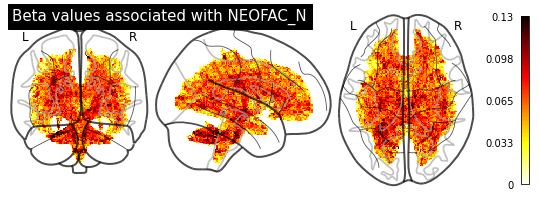

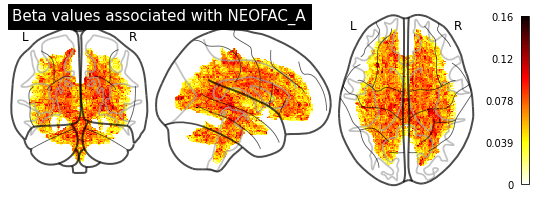

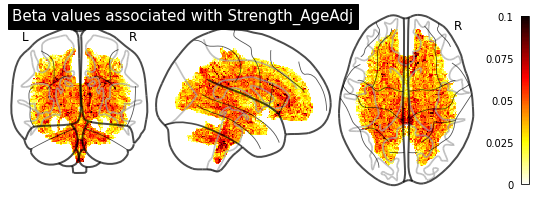

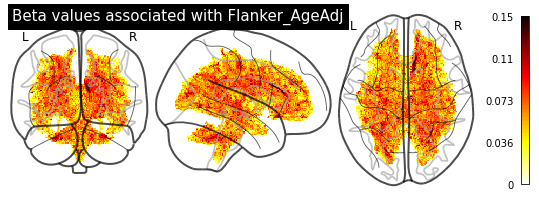

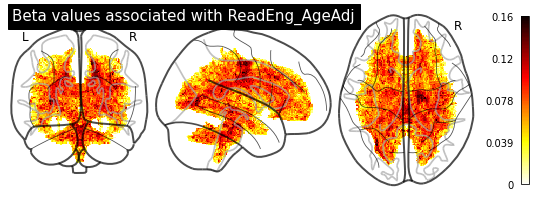

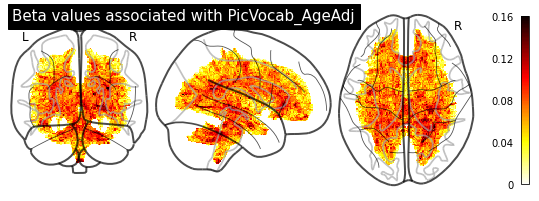

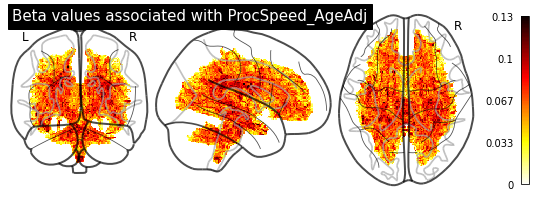

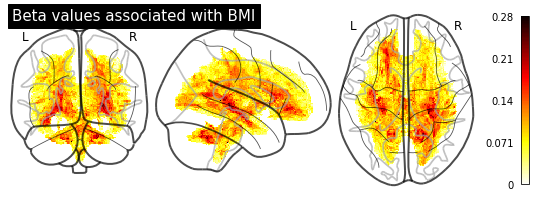

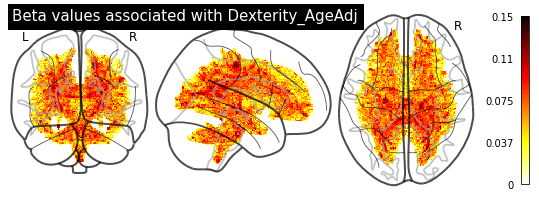

In [113]:
import nibabel as nb

'''
Now, we are ready to view the result of the multivariate regressions. Using our old mask, we convert the data arrays 
into a new format that can be plotted. 

Mrtrix3 is superior to Nilearn's plotting utility in every aspect and should be used instead whenever possible.
'''

old_mask = "/data/neuralabc/pirami/preprocess/Group_averages/masks/T1_5tt_warped_multcon_cubic_mean_vol2_WM_thr0p9_bin.nii.gz"

for var in dependent_variables:
    plotting.plot_glass_brain(masking.unmask(np.array(list(beta_all[var].values())), old_mask), colorbar=True, title=f'Beta values associated with {var}')
    plt.show()
    #Save the unmasked data to a nii.gz file as well so that we could plot it using Mrtrix3
    nb.save(masking.unmask(np.array(list(beta_all[var].values())), old_mask), f'Full_brain_beta_{var}.nii.gz')